# Likelihood Scans and Signal Strength Measurements

Now that you are very familiar with asymptotic discovery significance estimates and nuisance parameters, let us see what else we can do with the likelihood function.

Very often, one plots two times the negative log-likelihood, $-2\cdot\log(\mathcal{L})$, against the parameter of interest, because there is a nice graphical way to determine the uncertainty of the parameter estimate.

Let's get started by by agin importing our `asymptotic_discovery_fit` function and `make_nll_func` the `make_nll_func`, which is just creating the likelihood function without fitting it or fixing any paramters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from geeksw.stats.statistics_tools import asymptotic_discovery_fit, make_nll_func

Again, we take as a "toy" experiment an old version of the CMS analysis results:

In [3]:
datacard = pd.DataFrame(dict(WWW=[27.90, 16.07, 0, 0, 0],
                             WWZ=[0.91, 0.91, 8.57, 0, 0],
                             WZZ=[0.18, 0.01, 0.34, 1.08, 0.01],
                             ZZZ=[0, 0, 0.07, 0.25, 0.41],
                             VH_WWW=[17.62, 8.47, 0, 0, 0],
                             VH_WWZ=[0, 0,  5.6+0.09+0.17, 0, 0],
                             VH_WZZ=[0.0, 0, 0, 0, 0],
                             VH_ZZZ=[0.0, 0, 0, 0, 0],
                             B=[447.21, 94.99, 15.76, 0.55, 0.06]),
                        index=["SSplusJets", "3leptons", "4leptons", "5leptons", "6leptons"])
datacard.index.name = "bin"

In [4]:
datacard

,WWW,WWZ,WZZ,ZZZ,VH_WWW,VH_WWZ,VH_WZZ,VH_ZZZ,B
bin,,,,,,,,,
SSplusJets,27.90,0.91,0.18,0.00,17.62,0.00,0.0,0.0,447.21
3leptons,16.07,0.91,0.01,0.00,8.47,0.00,0.0,0.0,94.99
4leptons,0.00,8.57,0.34,0.07,0.00,5.86,0.0,0.0,15.76
5leptons,0.00,0.00,1.08,0.25,0.00,0.00,0.0,0.0,0.55
6leptons,0.00,0.00,0.01,0.41,0.00,0.00,0.0,0.0,0.06


For this example, we consider all the posible *VVV* final states as one signal, and all *VH_VVV* final states as another signal:

In [5]:
signal_strengths = dict(mu_vvv="WWZ+WZZ+ZZZ", mu_vh="VH_WWZ+VH_WZZ+VH_ZZZ")

## One Dimentional Likelihood Scans

First, we forget about any fitting and just scan the likelihood function over one parameter of interest, while fixing the other one to the standart model value, where the expected signal strength is one.

We build the likelihood function from the datacard and the signal strength definition:

In [6]:
nll_func = make_nll_func(datacard, signal_strengths)

Let's compute the likelihood for different values of the $VVV$ signal strength between 0 and 2. Unfortunately, the likelihood function is not vectorized, so you need to loop over the values in a Python loop:

In [7]:
mus = np.linspace(0.0, 2.0, 200)
nlls = np.zeros(len(mus))

for i, mu in enumerate(mus):
    nlls[i] = nll_func(mu_vvv=mu, mu_vh=1.0)

Since we are only interested in the minimum of the negative log-likelihood and not the absolute value, we can subtract the minimum value to have the minimum at zero:

In [8]:
nlls = nlls - np.min(nlls)

Finally, do the plot:

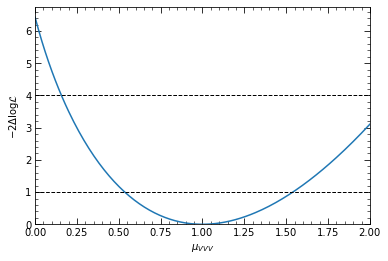

In [9]:
plt.plot(mus, 2.*nlls)
plt.xlim(0, 2.0)
plt.ylim(0, plt.ylim()[1])
plt.plot([0,2.0], [1,1], 'k--', linewidth=1)
plt.plot([0,2.0], [4,4], 'k--', linewidth=1)
plt.xlabel(r"$\mu_{VVV}$")
plt.ylabel(r"$-2\Delta\log{\mathcal{L}}$")
plt.show()

That looks like something you'd see in a paper by CMS or ATLAS! But why did I draw these dashed constant lines?

The best estimate for the signal strengh is at the minimum, so here at 1.0 by definition as long as we only look at Monte Carlo. The **variance of the maximum likelihood estimator** can be determined by figuring out in which interval $-2\Delta\log{\mathcal{L}}$ is smaller than one. This corresponds to one standard deviation is the case of a Gaussian likelihood and the interval can be interpreted as a **confidence interval**.

If you want to understand this in detail, I recommend that you read a bit more about likelihood fits, for example in Glen Cowans book "[Statistical Data Analysis](https://www.amazon.de/dp/0198501552)" (Section 6.6). The general argument invokes more sophisticated statistical concepts like the [Cranér-Rao bound](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93Rao_bound).

However, this is really easy to understand in the case of a Gaussian Likelihood, which is usually true in the large sample limit due to the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). Just look at the logarithm of a Gaussian distribution! It will get clear that $-2\Delta\log{\mathcal{L}}$ will be one when you are one standard deviation away from the mean.

The cool thing however is that this method of determining confidence intervals is also valid in the non-Gaussian case.

## Profiled One Dimensional Likelihood Scans

But what do we do if there is more than one unknown parameter? For example when we have plenty of nuisance parameters, or multiple parameters of interest like in our case with $\mu_{VVV}$ and $\mu_{VH}$?

In that case, you can't fix these other parameters to a certain value when you do the likelihood scan, but you have to optimize them for *every single value* of the parameter of interest that you scan over. This is called "profiling out" the other parameters, like in the profile likelihood ratio we computed for the discovery test. It will get apparent why it's called profiling in a minute.

Since not all parameters have to be fixed now, we can't just use the likelihood function but need to do some fits again. Fortunately, the `asymptotic_discovery_fit` also returns the negative log-likelihood value in the fit result:

In [10]:
fit_result = asymptotic_discovery_fit(datacard, signal_strengths)
print("NLL:", fit_result.nll_value)
fit_result.df_mu

NLL: -3098.1474309132514


,value,error,precision,significance,p_value
mu_vvv,1.000405,0.850434,0.850090,1.768385,0.038498
mu_vh,0.999386,1.596011,1.596992,0.572297,0.283560


There is also another feature of the fitting function that we can use now. You can fit parameters for *all fits* (that means also during the determination of the profile likelihood ratio and therefore significance) with the `fixed_params` keyword argument, which takes a dictionary of parameter names and values to fix.

In [11]:
fit_result = asymptotic_discovery_fit(datacard, signal_strengths, fixed_params={"mu_vh" : 1.0})
print("NLL:", fit_result.nll_value)
fit_result.df_mu

NLL: -3098.1474310152057


,value,error,precision,significance,p_value
mu_vvv,0.999945,0.502931,0.502958,2.535136,0.00562
mu_vh,1.000000,NaN,NaN,NaN,NaN


Significance estimate is not really meaningful for other signal strength estimates than one, so these columns are disabled when you fix paramteres. As expected, the sensitivity to $\mu_{VVV}$ grows when $\mu_{VH}$ is fixed and not fit at the same time.

In the following, we use this `fixed_params` argument to fix $\mu_{VVV}$ to the scan value, but let $\mu_{VH}$ float free. How do you expect the resulting likelihood curve to change?

We use a `linspace` with a little less points this time (20 instead of 200), because fitting for each point takes of course longer than just evaluating the likelihood function for fixed parameters.

In [12]:
mus = np.linspace(0, 2.5, 20)
nlls = np.zeros(len(mus))
nlls_profile = np.zeros(len(mus))

for i, mu in enumerate(mus):
    nlls[i] = asymptotic_discovery_fit(datacard,
                                        signal_strengths,
                                        fixed_params={"mu_vvv" : mu,
                                                      "mu_vh" : 1.0}
                                       ).nll_value
    nlls_profile[i] = asymptotic_discovery_fit(datacard,
                                               signal_strengths,
                                               fixed_params={"mu_vvv" : mu}
                                              ).nll_value
    
nlls = nlls - np.min(nlls)
nlls_profile = nlls_profile - np.min(nlls_profile)

Finally, the plot:

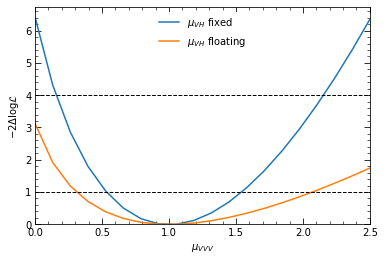

In [13]:
plt.plot(mus, 2.*nlls, label=r"$\mu_{VH}$ fixed")
plt.plot(mus, 2.*nlls_profile, label=r"$\mu_{VH}$ floating")
plt.xlim(0, 2.5)
plt.plot([0,2.5], [1,1], 'k--', linewidth=1)
plt.plot([0,2.5], [4,4], 'k--', linewidth=1)
plt.xlabel(r"$\mu_{VVV}$")
plt.ylabel(r"$-2\Delta\log{\mathcal{L}}$")
plt.ylim(0, plt.ylim()[1])
plt.legend()
plt.show()

Of course the likelihood increases if we allow $\mu_{VH}$ to take the best fit value for every value of $\mu_{VVV}$! That's why the negative log likelihood decreases and the confidence interval for $\mu_{VVV}$ grows. In fact, it also becomes asymmetric, so if you'd quote this signal strength as a measurement result, you would have to give one upper and one lower uncertainty.

Very often, the parameters that we profile over are the nuisance parameters which represent systematic uncertainties. In such a case, the profile likelihood curve gives you the result including systematic uncertainties, while fixing the nuisance parameters gives you a curve that only shows the statistical uncertainty.

In high energy physics, we often show both scans in a single plot to highlight the impact of nuisance parameters. In particular, one can obtain a value for the final systematic uncertainty by subtracting the statistical uncertainty from the total uncertainty in quartrature.

## Two Dimensional Likelihood Scans

Finally, we will take a look at two dimensional likelihood scans, which are often done when you have two potentionally correlated paramteres of interest. Our two parameters of interest are of course $\mu_{VVV}$ and $\mu_{VH}$.

If we keep on ignoring systematic uncertainties, there are no other nuisance parameters in our model and we don't need to do any fitting. Profiling over nuisance parameters would take too long here anyway, because for the 2D plot we need of course to evaluate exponentially more points to have a clean figure.

Anyway, we just get the fit result once so we know the value of the minimum and can subtract it later:

In [14]:
fit_result = asymptotic_discovery_fit(datacard, signal_strengths, [])

Next, we write a little wrapper function around our likelihood function which can also accept arrays of parameters:

In [15]:
def vectorized_two_nll_func(x, y):
    results = []
    for xi, yi in zip(x.flatten(), y.flatten()):
        results.append(nll_func(mu_vvv=xi, mu_vh=yi, beta=1.))
    return 2 * (np.array(results).reshape(x.shape) - fit_result.nll_value)

We can conveniently use this function to evaluate a "meshgrid" of points in the two dimensional plane (inspired by [this matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/contour_demo.html)):

In [16]:
x = np.linspace(0.0, 2.23, 30)
y = np.linspace(-1.0, 2.8, 30)

X, Y = np.meshgrid(x, y)
s = np.sqrt(vectorized_two_nll_func(X, Y))

Note that in the end we too the  square root to plot something which would correspond to the standard deviation in the case of a Gaussian likelihood. Let's do the plot:

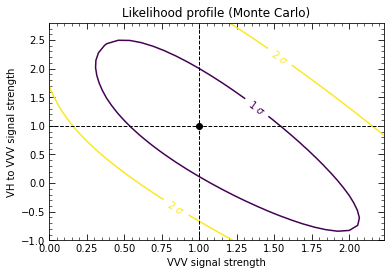

In [17]:
cs = plt.contour(X, Y, s, levels=[1.0, 2.0])
plt.gca().clabel(cs, inline=1, fontsize=10, fmt=r'%1.0f $\sigma$')
plt.xlim(*plt.xlim())
plt.ylim(*plt.ylim())
plt.plot([1, 1], [-1.0, 2.8], 'k--', linewidth=1.0)
plt.plot([0, 2.2], [1,1], 'k--', linewidth=1.0)
plt.plot(*fit_result.df_mu.value, 'ko')
plt.xlabel("VVV signal strength")
plt.ylabel("VH to VVV signal strength")
plt.title("Likelihood profile (Monte Carlo)")
plt.show()

Now it should get clear how everything is connected and why the "profiled likelihood" is called like that! Plase compare this 2D scan to the previous plot which compared the profiled likelihood scan with the scan there $\mu_{VH}$ was fixed. You should observe:

If you read the 2D plot at $\mu_{VH} = 1.0$ (so 1.0 on the y-axis), you will find back the confidence interval that we obtained without profiling. If you take a close look at the purple $1 \sigma$ confidence area, then you observe that the profile of the area when projected on the x-axis ($\mu_{VVV}$) extends from roughtly 0.3 to 2.0. That is exactly the same answer we got with the profiled likelihood scan!

# Conclusion and Tasks

You now know about all the statistical tools you can use to interpret your four-lepton data:
* Estimating discovery significance with asymptotic formulas
* Likelihood scans in 1D and 2D
* Profiles Likelihood scans
* Measuring signal strength with confidence interval
* How to treat systematic uncertainties using nuisance parameters